# Trying our different learning rate schedules

Using the default network configuration, the goal is to get to the reference valid loss as quickly as possible.

1. Typical learning rate decau
2. One cycle LR

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.score import *
from src.train_nn import *
import matplotlib.pyplot as plt

/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/frame

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(3)
limit_mem()

In [4]:
datadir = '/data/stephan/WeatherBench/5.625deg/'
var_dict = {'geopotential': ('z', [500]), 'temperature': ('t', [850])}
output_vars = None
filters = [64, 64, 64, 64, 2]
kernels = [5, 5, 5, 5, 5]
lead_time = 72
batch_size = 128
activation = 'elu'

In [5]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [6]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [7]:
324336 /100000

3.24336

In [8]:
dg_train = DataGenerator(ds_train, var_dict, lead_time, batch_size=batch_size, 
                         output_vars=output_vars, norm_subsample=100000)
dg_valid = DataGenerator(ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False, output_vars=output_vars)
dg_test =  DataGenerator(ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False, output_vars=output_vars)
print(f'Mean = {dg_train.mean}; Std = {dg_train.std}')

DG start 08:03:44.600137
DG normalize 08:03:44.617996
DG load 08:03:48.418884
Loading data into RAM
DG done 08:05:07.073975
DG start 08:05:07.074241
DG normalize 08:05:07.081251
DG load 08:05:07.089127
Loading data into RAM
DG done 08:05:08.335510
DG start 08:05:08.336194
DG normalize 08:05:08.347442
DG load 08:05:08.357824
Loading data into RAM
DG done 08:05:09.841732
Mean = <xarray.DataArray 'z' (level: 2)>
array([53999.11   ,   273.80154], dtype=float32)
Coordinates:
  * level        (level) int64 500 850
    level_names  (level) <U5 'z_500' 't_850'; Std = <xarray.DataArray 'z' (level: 2)>
array([3353.02    ,   15.909879], dtype=float32)
Coordinates:
  * level        (level) int64 500 850
    level_names  (level) <U5 'z_500' 't_850'


In [9]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 2)>
 array([53999.11   ,   273.80154], dtype=float32)
 Coordinates:
   * level        (level) int64 500 850
     level_names  (level) <U5 'z_500' 't_850',
 <xarray.DataArray 'z' (level: 2)>
 array([3353.02    ,   15.909879], dtype=float32)
 Coordinates:
   * level        (level) int64 500 850
     level_names  (level) <U5 'z_500' 't_850')

## Learning rate decay

In [10]:
class LRUpdate(object):
    def __init__(self, init_lr, step, divide):
        # From goo.gl/GXQaK6
        self.init_lr = init_lr
        self.step = step
        self.drop = 1. / divide

    def __call__(self, epoch):
        lr = self.init_lr * np.power(self.drop, np.floor((epoch) / self.step))
        print(f'Learning rate = {lr}')
        return lr

In [31]:
lrs = LRUpdate(2.5e-4, 4, 3)

Learning rate = [2.50000000e-04 2.50000000e-04 2.50000000e-04 2.50000000e-04
 8.33333333e-05 8.33333333e-05 8.33333333e-05 8.33333333e-05
 2.77777778e-05 2.77777778e-05]


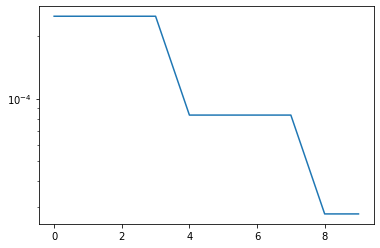

In [36]:
plt.plot(lrs(np.arange(10)))
plt.yscale('log')

In [37]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.Adam(), 'mse')

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 64, 2)         0         
_________________________________________________________________
lambda_25 (Lambda)           (None, 36, 68, 2)         0         
_________________________________________________________________
periodic_conv2d_25 (Periodic (None, 32, 64, 64)        3264      
_________________________________________________________________
lambda_26 (Lambda)           (None, 36, 68, 64)        0         
_________________________________________________________________
periodic_conv2d_26 (Periodic (None, 32, 64, 64)        102464    
_________________________________________________________________
lambda_27 (Lambda)           (None, 36, 68, 64)        0         
_________________________________________________________________
periodic_conv2d_27 (Periodic (None, 32, 64, 64)        102464    
__________

In [ ]:
h = model.fit_generator(dg_train, epochs=40, validation_data=dg_valid, 
                    callbacks=[keras.callbacks.LearningRateScheduler(lrs)])

Learning rate = 0.00025
Epoch 1/40
2534/2534 [==============================] - 179s 70ms/step - loss: 7.8587 - val_loss: 7.2469
Learning rate = 0.00025
Epoch 2/40
2534/2534 [==============================] - 178s 70ms/step - loss: 7.0348 - val_loss: 6.8925
Learning rate = 0.00025
Epoch 3/40
2534/2534 [==============================] - 178s 70ms/step - loss: 6.7613 - val_loss: 6.7130
Learning rate = 0.00025
Epoch 4/40
2534/2534 [==============================] - 178s 70ms/step - loss: 6.5858 - val_loss: 6.7136
Learning rate = 8.333333333333333e-05
Epoch 5/40
2534/2534 [==============================] - 178s 70ms/step - loss: 6.4053 - val_loss: 6.5001
Learning rate = 8.333333333333333e-05
Epoch 6/40
2534/2534 [==============================] - 178s 70ms/step - loss: 6.3488 - val_loss: 6.4579
Learning rate = 8.333333333333333e-05
Epoch 7/40
2534/2534 [==============================] - 178s 70ms/step - loss: 6.2976 - val_loss: 6.4019
Learning rate = 8.333333333333333e-05
Epoch 8/40
2534/2

In [40]:
h

[autoreload of h5py failed: Traceback (most recent call last):
  File "/home/stephan/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/stephan/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/stephan/miniconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/stephan/miniconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/stephan/miniconda3/lib/python3.6/site-packages/h5py/__init__.py", line 55, in <module>
    from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z, h5

## One Cycle

In [6]:
from src.clr import LRFinder